#  Instructions (please read carefully): 

1. All answers should be included in this file, either in a Code or Markdown cell. Extras have been created to indicate where to respond, but you can add additional ones if you see fit. **Do NOT delete any of the existing code/text.**
2. Use provided code as you wish, write your own if you prefer. **Do NOT delete any of the existing code/text.**
3. All conceptual questions must be answered in a Markdown cell, but you don't have to worry about formal equation formatting if you don't feel comfortable with it. 
4. There are 5 problems in total.
5. Allowed to use: All class notes, slides, Jupyter Notebooks, Homework solutions, tutorials.
6. Not allowed: <br>
    i. General web, google, or other blogs etc., <br>
    ii. Communicate with others during exam. <br>
    iii. Share exam with others at ANY time.
    
7. You must submit your completed Jupyter notebook within **3 and 1/2 hours after start time**. This time includes extra time for downloading, uploading, technical/internet difficulties, potential installation issues. DO NOT keep working to submit exam beyond 3 hrs 15 minutes, unless facing an issue which you should have communicated with instructor. Last minute emails, because "sumbit" did not work will NOT be accepted. 
8. Because everyone is taking exam at a different time, no clarification questions will be answered on Piazza. Any posts will be deleted.
9. You are only allowed to contact Dr. Boukouvala on her phone (text is better: 201-221-6380) in case of an emergency. Please state your name and issue in the text.

# Honor Code Statement (please provide electronic signature):

I agree to follow Georgia Tech's honor code and follow the instructions provided above. 


**Name:**

**Date:**

**Download time (EST):**

# Problem 1: Short Answer Questions (15 pts)


**Answer below concisely (~2 sentences) (5 pts each):** <br>

<ol>  
    
  <li> Provide two reasons why it is important to know whether an optimization formulation is convex vs nonconvex. </li> <br>
       
  <li> Describe the relationship between Physics-Informed ML and Lagrangian Duality. </li> <br>
    
  <li> Explain two key differences between Robust Optimization and Stochastic Optimization. </li> <br>
    
</ol>
  

## Answer Problem 1 Here:

### 1.1: 

### 1.2:

### 1.3:


## Problem 2: Short Problems (20 pts)

## 2.1 (10 points): 
Below is code from your homework 4 on training a Generalized Linear Regression Model with only up to 6 terms, using a MINLP formulation. Assume you only have access to a MILP solver, so this problem needs to be reformulated. Make ALL the necessary edits to the code to make it into an MILP problem. 

### YOU CANNOT RUN THIS CODE, and do not need to RUN it. Just edit it!!

In [ ]:
#Code is copied here to remind you what is being done, but you cannot run it without access to X, feature_list etc. 
# DO NOT ATTEMPT TO RUN!
X = mat_1(np.vstack((x1,x2)).T) #imported data
from pyomo.environ import *     #loaded Pyomo


m = ConcreteModel()
m.a = Var(feature_list, within=Reals)
m.b = Var(feature_list, within=Binary)

m.obj = Objective(expr = sum((sum(m.a[j]*m.b[j]*X[i,j] for j in feature_list)-f[i])**2 for i in points_list), sense = minimize)

m.con = Constraint(expr = sum(b[j] for j in feature_list) <= 6)

solver = SolverFactory('baron')
solver.solve(m)



##### Modified code
'''
steps taken:
1) objective function is sum of squared errors, we can change it to sum of absolute errors
2) introduce a big-M formulation to linearize
3) this is optional : if the solver cannot handle absolute values, write it as (z+) + (z-) formulation

'''

####-------------------------------------------------- if solver can handle abs values:

X = mat_1(np.vstack((x1,x2)).T) #imported data
from pyomo.environ import *     #loaded Pyomo


m = ConcreteModel()
m.a = Var(feature_list, within=Reals)
m.b = Var(feature_list, within=Binary)
m.y = Var(points_list, feature_list, within=NonNegativeReals)


m.obj = Objective(expr= sum( abs( sum(m.y[i,j] for j in feature_list) - f[i] ) for i in points_list ), \
                  sense=minimize)

m.con1 = Constraint(expr = sum(b[j] for j in feature_list) <= 6)

m.con2 = ConstraintList()
M = 1e8

for i in points_list:
    for j in feature_list:
        m.con2.add(m.y[i,j] <= m.b[j] * X[i,j] * M)
        m.con2.add(m.y[i,j] <= m.a[j] * X[i,j])
        m.con2.add(m.y[i,j] >= m.a[j] * X[i,j] - (1 - m.b[j]) * M)

solver = SolverFactory('your MILP solver')
solver.solve(m)




####--------------------------------------------------  if solver cannot handle abs values


X = mat_1(np.vstack((x1,x2)).T) #imported data
from pyomo.environ import *     #loaded Pyomo


m = ConcreteModel()
m.a = Var(feature_list, within=Reals)
m.b = Var(feature_list, within=Binary)
m.ypred = Var(points_list, feature_list, within=NonNegativeReals)
m.zp = Var(points_list, within=NonNegativeReals)
m.zn = Var(points_list, within=NonNegativeReals)

m.con1 = Constraint(expr = sum(b[j] for j in feature_list) <= 6)

m.con2 = ConstraintList()
M = 1e8

for i in points_list:
    for j in feature_list:
        m.con2.add(m.y[i,j] <= m.b[j] * X[i,j] * M)
        m.con2.add(m.y[i,j] <= m.a[j] * X[i,j])
        m.con2.add(m.y[i,j] >= m.a[j] * X[i,j] - (1 - m.b[j]) * M)

        
def con_rule(m, i):
    return sum(m.ypred[i,j] for j in feature_list) - f[i]  == m.zp[i] - m.zn[i]

m.con3 = Constraint(points_list, rule=con_rule)

def ae(m):
    return sum(zp[i] + zm[i] for i in points_list)

m.obj = Objective(rule=ae, sense=minimize)


solver = SolverFactory('your MILP solver')
solver.solve(m)

## 2.2: (10 points):
Below you will find an Integer Programming formulation. Reproduce what a branch-and-bound solver would do in the background to solve this problem. Be aware of the following:
1. You do not have to write many pyomo formulations, just use the one you have, make minor edits to it--> solve--> get a solution, and report that solution to your markdown cell below explaining your b&b tree.
2. In your markdown cell below, report for each of your "nodes" (starting with "0" or head node), and going further down the tree: 
(a) What has been "relaxed" and fixed, 
(b) Optimal solution, best UB, best LB, 
(c) whether it is pruned and why.
3. Complete the entire tree until no further nodes are active to get full points
4. Finally report optimal solution.

In [1]:
from pyomo.environ import *
import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger('pyomo.core').setLevel(logging.ERROR)
    
m = ConcreteModel()

#solve relaxed problem
m.x1 = Var(within = Reals, bounds = (0,1))
m.x2 = Var(within = Reals, bounds = (0,1))
m.x3 = Var(within = Reals, bounds = (0,1))
m.x4 = Var(within = Reals, bounds = (0,1))
m.x5 = Var(within = Reals, bounds = (0,1))
 
m.con = Constraint(expr= 8*m.x1 + 7*m.x2 + 11*m.x3 + 6*m.x4 + 19*m.x5 <= 25)
m.obj = Objective(expr = 23*m.x1 + 19*m.x2 + 28*m.x3 + 14*m.x4 + 44*m.x5, sense = maximize)
solver = SolverFactory('baron')
solver.solve(m)
print('relaxed problem')
print('x1 : ' + str(value(m.x1)), 
      ' x2 : ' + str(value(m.x2)),
      ' x3 : ' + str(value(m.x3)),
      ' x4 : ' + str(value(m.x4)),
      ' x5 : ' + str(value(m.x5)),
      ' obj : ' + str(value(m.obj)))


#fix x3 = 1
m.x1 = Var(within = Reals, bounds = (0,1))
m.x2 = Var(within = Reals, bounds = (0,1))
m.x3 = Var(within = Reals, bounds = (1,1))
m.x4 = Var(within = Reals, bounds = (0,1))
m.x5 = Var(within = Reals, bounds = (0,1))
 
m.con = Constraint(expr= 8*m.x1 + 7*m.x2 + 11*m.x3 + 6*m.x4 + 19*m.x5 <= 25)
m.obj = Objective(expr = 23*m.x1 + 19*m.x2 + 28*m.x3 + 14*m.x4 + 44*m.x5, sense = maximize)
solver = SolverFactory('baron')
solver.solve(m)
print('\nfix x3 = 1')
print('x1 : ' + str(value(m.x1)), 
      ' x2 : ' + str(value(m.x2)),
      ' x3 : ' + str(value(m.x3)),
      ' x4 : ' + str(value(m.x4)),
      ' x5 : ' + str(value(m.x5)),
      ' obj : ' + str(value(m.obj)))

#fix x3 = 0
m.x1 = Var(within = Reals, bounds = (0,1))
m.x2 = Var(within = Reals, bounds = (0,1))
m.x3 = Var(within = Reals, bounds = (0,0))
m.x4 = Var(within = Reals, bounds = (0,1))
m.x5 = Var(within = Reals, bounds = (0,1))
 
m.con = Constraint(expr= 8*m.x1 + 7*m.x2 + 11*m.x3 + 6*m.x4 + 19*m.x5 <= 25)
m.obj = Objective(expr = 23*m.x1 + 19*m.x2 + 28*m.x3 + 14*m.x4 + 44*m.x5, sense = maximize)
solver = SolverFactory('baron')
solver.solve(m)
print('\nfix x3 = 0')
print('x1 : ' + str(value(m.x1)), 
      ' x2 : ' + str(value(m.x2)),
      ' x3 : ' + str(value(m.x3)),
      ' x4 : ' + str(value(m.x4)),
      ' x5 : ' + str(value(m.x5)),
      ' obj : ' + str(value(m.obj)))

#fix x3 = 1, x2 = 0
m.x1 = Var(within = Reals, bounds = (0,1))
m.x2 = Var(within = Reals, bounds = (0,0))
m.x3 = Var(within = Reals, bounds = (1,1))
m.x4 = Var(within = Reals, bounds = (0,1))
m.x5 = Var(within = Reals, bounds = (0,1))
 
m.con = Constraint(expr= 8*m.x1 + 7*m.x2 + 11*m.x3 + 6*m.x4 + 19*m.x5 <= 25)
m.obj = Objective(expr = 23*m.x1 + 19*m.x2 + 28*m.x3 + 14*m.x4 + 44*m.x5, sense = maximize)
solver = SolverFactory('baron')
solver.solve(m)
print('\nfix x3 = 1, x2 = 0')
print('x1 : ' + str(value(m.x1)), 
      ' x2 : ' + str(value(m.x2)),
      ' x3 : ' + str(value(m.x3)),
      ' x4 : ' + str(value(m.x4)),
      ' x5 : ' + str(value(m.x5)),
      ' obj : ' + str(value(m.obj)))


#fix x3 = 1, x2 = 1
m.x1 = Var(within = Reals, bounds = (0,1))
m.x2 = Var(within = Reals, bounds = (1,1))
m.x3 = Var(within = Reals, bounds = (1,1))
m.x4 = Var(within = Reals, bounds = (0,1))
m.x5 = Var(within = Reals, bounds = (0,1))
 
m.con = Constraint(expr= 8*m.x1 + 7*m.x2 + 11*m.x3 + 6*m.x4 + 19*m.x5 <= 25)
m.obj = Objective(expr = 23*m.x1 + 19*m.x2 + 28*m.x3 + 14*m.x4 + 44*m.x5, sense = maximize)
solver = SolverFactory('baron')
solver.solve(m)
print('\nfix x3 = 1, x2 = 1')
print('x1 : ' + str(value(m.x1)), 
      ' x2 : ' + str(value(m.x2)),
      ' x3 : ' + str(value(m.x3)),
      ' x4 : ' + str(value(m.x4)),
      ' x5 : ' + str(value(m.x5)),
      ' obj : ' + str(value(m.obj)))


#fix x3 = 0, x5 = 0
m.x1 = Var(within = Reals, bounds = (0,1))
m.x2 = Var(within = Reals, bounds = (0,1))
m.x3 = Var(within = Reals, bounds = (0,0))
m.x4 = Var(within = Reals, bounds = (0,1))
m.x5 = Var(within = Reals, bounds = (0,0))
 
m.con = Constraint(expr= 8*m.x1 + 7*m.x2 + 11*m.x3 + 6*m.x4 + 19*m.x5 <= 25)
m.obj = Objective(expr = 23*m.x1 + 19*m.x2 + 28*m.x3 + 14*m.x4 + 44*m.x5, sense = maximize)
solver = SolverFactory('baron')
solver.solve(m)
print('\nfix x3 = 0, x5 = 0')
print('x1 : ' + str(value(m.x1)), 
      ' x2 : ' + str(value(m.x2)),
      ' x3 : ' + str(value(m.x3)),
      ' x4 : ' + str(value(m.x4)),
      ' x5 : ' + str(value(m.x5)),
      ' obj : ' + str(value(m.obj)))

#fix x3 = 0, x5 = 1
m.x1 = Var(within = Reals, bounds = (0,1))
m.x2 = Var(within = Reals, bounds = (0,1))
m.x3 = Var(within = Reals, bounds = (0,0))
m.x4 = Var(within = Reals, bounds = (0,1))
m.x5 = Var(within = Reals, bounds = (1,1))
 
m.con = Constraint(expr= 8*m.x1 + 7*m.x2 + 11*m.x3 + 6*m.x4 + 19*m.x5 <= 25)
m.obj = Objective(expr = 23*m.x1 + 19*m.x2 + 28*m.x3 + 14*m.x4 + 44*m.x5, sense = maximize)
solver = SolverFactory('baron')
solver.solve(m)
print('\nfix x3 = 0, x5 = 0')
print('x1 : ' + str(value(m.x1)), 
      ' x2 : ' + str(value(m.x2)),
      ' x3 : ' + str(value(m.x3)),
      ' x4 : ' + str(value(m.x4)),
      ' x5 : ' + str(value(m.x5)),
      ' obj : ' + str(value(m.obj)))

#fix x3 = 1, x2 = 1, x1 = 0
m.x1 = Var(within = Reals, bounds = (0,0))
m.x2 = Var(within = Reals, bounds = (1,1))
m.x3 = Var(within = Reals, bounds = (1,1))
m.x4 = Var(within = Reals, bounds = (0,1))
m.x5 = Var(within = Reals, bounds = (0,1))
 
m.con = Constraint(expr= 8*m.x1 + 7*m.x2 + 11*m.x3 + 6*m.x4 + 19*m.x5 <= 25)
m.obj = Objective(expr = 23*m.x1 + 19*m.x2 + 28*m.x3 + 14*m.x4 + 44*m.x5, sense = maximize)
solver = SolverFactory('baron')
solver.solve(m)
print('\nfix x3 = 1, x2 = 1, x1 = 1')
print('x1 : ' + str(value(m.x1)), 
      ' x2 : ' + str(value(m.x2)),
      ' x3 : ' + str(value(m.x3)),
      ' x4 : ' + str(value(m.x4)),
      ' x5 : ' + str(value(m.x5)),
      ' obj : ' + str(value(m.obj)))


#fix x3 = 1, x2 = 1, x1 = 1
print('\nfix x3 = 1, x2 = 1, x1 = 1')
print('infeasible')


print ('\n\noptimum:')
#fix x3 = 1, x2 = 0
m.x1 = Var(within = Reals, bounds = (0,1))
m.x2 = Var(within = Reals, bounds = (0,0))
m.x3 = Var(within = Reals, bounds = (1,1))
m.x4 = Var(within = Reals, bounds = (0,1))
m.x5 = Var(within = Reals, bounds = (0,1))
 
m.con = Constraint(expr= 8*m.x1 + 7*m.x2 + 11*m.x3 + 6*m.x4 + 19*m.x5 <= 25)
m.obj = Objective(expr = 23*m.x1 + 19*m.x2 + 28*m.x3 + 14*m.x4 + 44*m.x5, sense = maximize)
solver = SolverFactory('baron')
solver.solve(m)
print('\nfix x3 = 1, x2 = 0')
print('x1 : ' + str(value(m.x1)), 
      ' x2 : ' + str(value(m.x2)),
      ' x3 : ' + str(value(m.x3)),
      ' x4 : ' + str(value(m.x4)),
      ' x5 : ' + str(value(m.x5)),
      ' obj : ' + str(value(m.obj)))


print ('\n\ncheck by restricting domain to binary:')
#fix x3 = 1, x2 = 0
m.x1 = Var(within = Binary)
m.x2 = Var(within = Binary)
m.x3 = Var(within = Binary)
m.x4 = Var(within = Binary)
m.x5 = Var(within = Binary)
 
m.con = Constraint(expr= 8*m.x1 + 7*m.x2 + 11*m.x3 + 6*m.x4 + 19*m.x5 <= 25)
m.obj = Objective(expr = 23*m.x1 + 19*m.x2 + 28*m.x3 + 14*m.x4 + 44*m.x5, sense = maximize)
solver = SolverFactory('baron')
solver.solve(m)
print('\nfix x3 = 1, x2 = 0')
print('x1 : ' + str(value(m.x1)), 
      ' x2 : ' + str(value(m.x2)),
      ' x3 : ' + str(value(m.x3)),
      ' x4 : ' + str(value(m.x4)),
      ' x5 : ' + str(value(m.x5)),
      ' obj : ' + str(value(m.obj)))

relaxed problem
x1 : 1.0  x2 : 1.0  x3 : 0.9090909090909088  x4 : 0.0  x5 : 0.0  obj : 67.45454545454544

fix x3 = 1
x1 : 1.0  x2 : 0.8571428571428571  x3 : 1.0  x4 : 0.0  x5 : 0.0  obj : 67.28571428571428

fix x3 = 0
x1 : 1.0  x2 : 1.0  x3 : 0.0  x4 : 1.0  x5 : 0.21052631578947367  obj : 65.26315789473685

fix x3 = 1, x2 = 0
x1 : 1.0  x2 : 0.0  x3 : 1.0  x4 : 1.0  x5 : 0.0  obj : 65.0

fix x3 = 1, x2 = 1
x1 : 0.875  x2 : 1.0  x3 : 1.0  x4 : 0.0  x5 : 0.0  obj : 67.125

fix x3 = 0, x5 = 0
x1 : 1.0  x2 : 1.0  x3 : 0.0  x4 : 1.0  x5 : 0.0  obj : 56.0

fix x3 = 0, x5 = 0
x1 : 0.75  x2 : 0.0  x3 : 0.0  x4 : 0.0  x5 : 1.0  obj : 61.25

fix x3 = 1, x2 = 1, x1 = 1
x1 : 0.0  x2 : 1.0  x3 : 1.0  x4 : 1.0  x5 : 0.05263157894736842  obj : 63.31578947368421

fix x3 = 1, x2 = 1, x1 = 1
infeasible


optimum:

fix x3 = 1, x2 = 0
x1 : 1.0  x2 : 0.0  x3 : 1.0  x4 : 1.0  x5 : 0.0  obj : 65.0


check by restricting domain to binary:

fix x3 = 1, x2 = 0
x1 : 0.9999999999999996  x2 : 0.0  x3 : 1.0  x4 : 1.

### Explain your tree structure here:


    1) relaxed problem
    x1 : 1.0  x2 : 1.0  x3 : 0.9090909090909088  x4 : 0.0  x5 : 0.0  obj : 67.45454545454544
    so fix x3

    2) fix x3 = 1
    x1 : 1.0  x2 : 0.8571428571428571  x3 : 1.0  x4 : 0.0  x5 : 0.0  obj : 67.28571428571428
    next,  branch on x2 by fixing the values

    3) fix x3 = 0
    x1 : 1.0  x2 : 1.0  x3 : 0.0  x4 : 1.0  x5 : 0.21052631578947367  obj : 65.26315789473685
    next,  branch on x5 by fixing the values

    4) fix x3 = 1, x2 = 0
    x1 : 1.0  x2 : 0.0  x3 : 1.0  x4 : 1.0  x5 : 0.0  obj : 65.0
    prune, we have an binary solution already

    5) fix x3 = 1, x2 = 1
    x1 : 0.875  x2 : 1.0  x3 : 1.0  x4 : 0.0  x5 : 0.0  obj : 67.125
    next, branch on x1 by fixing the values

    6) fix x3 = 0, x5 = 0
    x1 : 1.0  x2 : 1.0  x3 : 0.0  x4 : 1.0  x5 : 0.0  obj : 56.0
    prune, UB is less (compared to x2 branching, and we have an integer solution)
    

    7) fix x3 = 0, x5 = 0
    x1 : 0.75  x2 : 0.0  x3 : 0.0  x4 : 0.0  x5 : 1.0  obj : 61.25
    prune, UB is less (compared to x2 branching)

    8) fix x3 = 1, x2 = 1, x1 = 1
    x1 : 0.0  x2 : 1.0  x3 : 1.0  x4 : 1.0  x5 : 0.05263157894736842  obj : 63.31578947368421
    prune, UB is less (compared to parent branch)

    9) fix x3 = 1, x2 = 1, x1 = 1
    infeasible
    prune, infeasible problem
    

    optimum:
    fix x3 = 1, x2 = 0
    x1 : 1.0  x2 : 0.0  x3 : 1.0  x4 : 1.0  x5 : 0.0  obj : 65.0


    check by restricting domain to binary:
    fix x3 = 1, x2 = 0
    x1 : 0.9999999999999996  x2 : 0.0  x3 : 1.0  x4 : 1.0  x5 : 0.0  obj : 64.99999999999999

## Problem 3: Principal Component Analysis (20 pts)

The data loaded below is a large dataset containing various features for many patients tested for breast cancer. It is unclear whether all of the 30 measured inputs are independent. 

Your colleague performed PCA on this data set and reports that with only 2 PCs, they can capture almost all of the variability in the data. And only very few measurements are important. Looking at the code and plots below, do you agree?

A. If yes, which features are truly important and why?

A. If no, what would you change, and why? If you change it, explain how this changes the conclusions and why. How many PCs would you keep and are any features correlated?  

B. Once you have this final result, list 2 advantages of using PCA for this problem (i.e., what does it enable,..)?.


PC1: 98.20%
PC2: 1.62%
PC3: 0.16%
PC4: 0.01%
PC5: 0.01%
PC6: 0.00%
PC7: 0.00%
PC8: 0.00%
PC9: 0.00%
PC10: 0.00%
PC11: 0.00%
PC12: 0.00%
PC13: 0.00%
PC14: 0.00%
PC15: 0.00%
PC16: 0.00%
PC17: 0.00%
PC18: 0.00%
PC19: 0.00%
PC20: 0.00%
PC21: 0.00%
PC22: 0.00%
PC23: 0.00%
PC24: 0.00%
PC25: 0.00%
PC26: 0.00%
PC27: 0.00%
PC28: 0.00%
PC29: 0.00%
PC30: 0.00%
-------------------------------------------------------------------------------------------------------------
* variance captured by the  10  PCs :  99.99998946838417 %
-------------------------------------------------------------------------------------------------------------


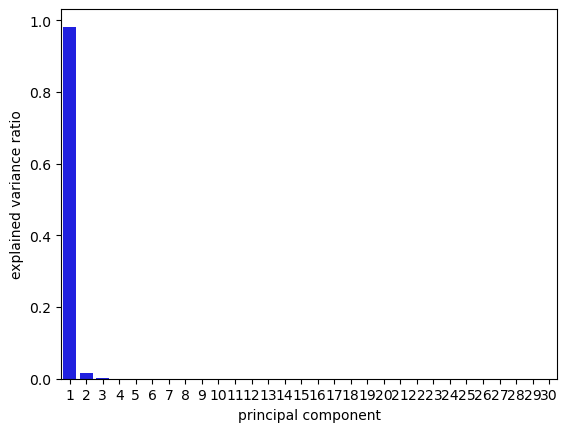

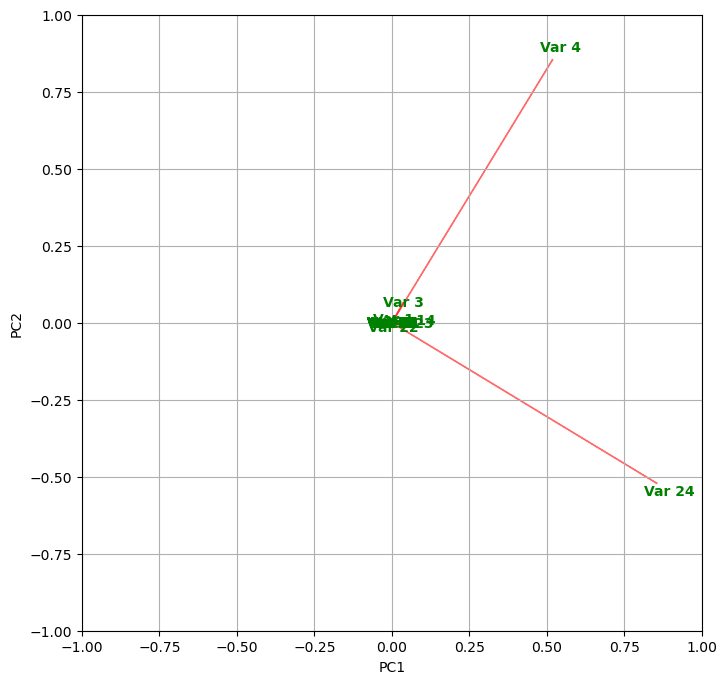

In [3]:
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## import data
from sklearn.datasets import load_breast_cancer
raw_data = load_breast_cancer()
X1 = pd.DataFrame(raw_data['data'], columns = raw_data['feature_names'])
x_labels = X1.columns

pca = PCA().fit(X1)
#print(pca.explained_variance_ratio_)
for i, evr in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {evr:.2%}")
print('-------------------------------------------------------------------------------------------------------------')
print('* variance captured by the ', str(10),' PCs : ',str(np.sum(pca.explained_variance_ratio_[0:10])*100), '%')
print('-------------------------------------------------------------------------------------------------------------')
#------------------------------------------------------------------------------------------------------- 
    
fig, ax = plt.subplots()
sns.barplot(x=np.arange(1, len(pca.explained_variance_ratio_)+1),y=pca.explained_variance_ratio_ ,color='blue')
ax.set_xlabel('principal component')
ax.set_ylabel('explained variance ratio')
plt.show()


# define function to plot loading plot
def loading_plot(score, coeff, labels=None):
    xs = score[:, 0]
    ys = score[:, 1]
    n = coeff.shape[0]
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0] * 1.05, coeff[i,1] * 1.05, "Var " + str(i + 1), color='g', ha='center', va='center', size=10, weight='bold')
        else:
            plt.text(coeff[i,0] * 1.05, coeff[i,1] * 1.05, labels[i], color='g', ha='center', va='center', size=10, weight='bold')

fig, ax = plt.subplots(figsize=(8, 8))
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

# call the function with the first two PCs
loading_plot(pca.components_[:,0:2], np.transpose(pca.components_[0:2, :]))
plt.show()

### Answer Problem 3 here:

#### This question is already covered in HW5, check HW5 solutions



## Problem 4: Surrogate Modeling & Optimization (25 pts)
A fixed data set is given to you, including a set of samples from a 2-dimensional black-box function. The goal is to find the minimum of this function, but you have no idea what this function is. The bounds for this function are [-500, 500] for both variables. 

Based on the data given, answer the following:

A. How do you think the data was collected and is it enough?

B. Explain what is happening within the cross validation for loop (how many times does it repeat, what is trained, what is calculated on how much data?)

C. Is this a good GP model fit? Feel free to change anything in the code to imrpove the GP fit, if there is anything. Describe what you tried. (Do not try other surrogate models, just GPR).

D. Use your best fit (regardless of whether you think it is good or not) to find a minimum. Use the code that is provided, which uses Powell's algorithm, which is a local trust-region method. Initialize the algorithm with 5 different points within the scaled space and report the optima you have found. Report all initial points and converged optima. What do you observe and why do you think that is?

E. After all the above steps, summarize whether you are happy with this result, if not, provide 2 suggestions on what to do next. 

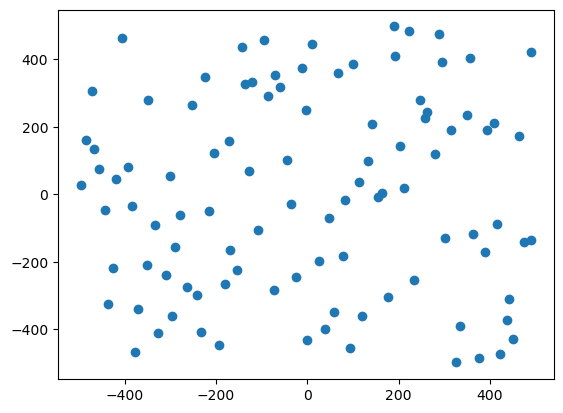

In [4]:
## Code of black-box function, data generation, plotting of DoE. Uncomment and modify anything you need to:
import numpy as np
import matplotlib.pyplot as plt

x= np.load('x.npy')
y = np.load('y.npy')

plt.scatter(x[:,0],x[:,1])

bounds1 = [-500,500]
bounds2 = [-500,500]

y_scaled = (y-min(y))/(max(y)-min(y))
x_scaled = (x- bounds1[0]) / (bounds1[1]-bounds1[0])

average CV error: 0.7335


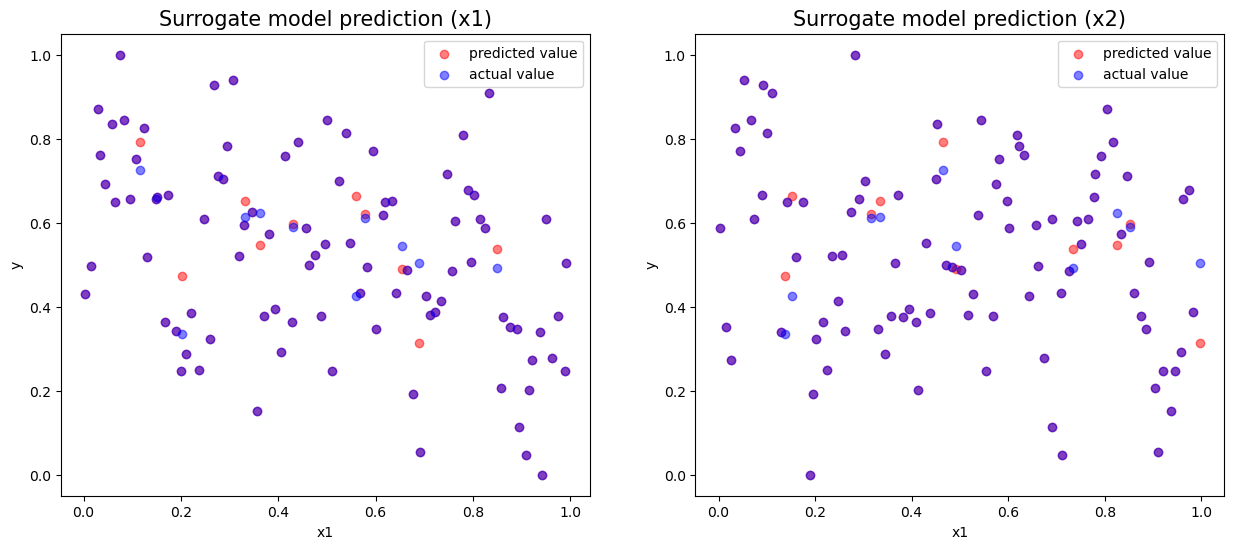

r2 score of the fit :  0.9720891527785852


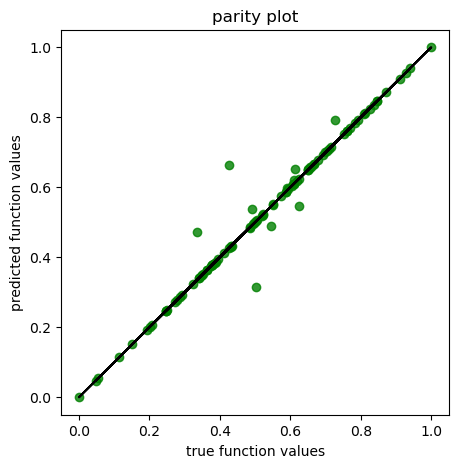

In [7]:
## Code to fit GPR model and use cross validation to calculate average CV error:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
import scipy as scp
from sklearn.metrics import r2_score

## CV from sklearn
from sklearn.model_selection import KFold

# create k-fold object
kf = KFold(n_splits=10, shuffle=True)

## create GPR model, with RBF kernel
gp = GPR(kernel=RBF(0.1, (1e-3, 1e3)))

cv_e = {}
cv_data = {}


# cross validation 
i = 0
for train_index, test_index in kf.split(x_scaled):
    
   # split training and testing set
    x_train, x_test = x_scaled[train_index], x_scaled[test_index]
    y_train, y_test = y_scaled[train_index], y_scaled[test_index]

    # fit GPR model
    gpmodel = gp.fit(x_train, y_train)

    # predict
    y_pred = np.array(gpmodel.predict(x_test))

    # calculate error
    err = sum((y_pred - y_test)**2)

    # record data and error
    cv_e[i] = err
    cv_data[i] = {'x': x_train,'y': y_train}
    #print('CV error for fold', i, ':', cv_e[i])

    i += 1

# pick the best model
best_cv = min(cv_e, key=cv_e.get)
#print('best model',best_cv)
best_data = cv_data[best_cv]
best_gp = gp.fit(best_data['x'],best_data['y'])

# calculate the average CV error
print(f"average CV error: {sum(cv_e[i] for i in range(len(cv_e)))/len(cv_e):.4f}")

# visualize prediction
fig, ax = plt.subplots(1, 2, figsize=(15,6))

y_gp = best_gp.predict(x_scaled)

ax[0].scatter(x_scaled[:,0], y_gp, color='red', alpha=0.5, label='predicted value')
ax[0].scatter(x_scaled[:,0], y_scaled, color='blue', alpha=0.5, label='actual value')
ax[0].set_xlabel('x1')
ax[0].set_ylabel('y')
ax[0].set_title('Surrogate model prediction (x1)', fontsize=15)
ax[0].legend()

ax[1].scatter(x_scaled[:,1], y_gp, color='red', alpha=0.5, label='predicted value')
ax[1].scatter(x_scaled[:,1], y_scaled, color='blue', alpha=0.5, label='actual value')
ax[1].set_xlabel('x1')
ax[1].set_ylabel('y')
ax[1].set_title('Surrogate model prediction (x2)', fontsize=15)
ax[1].legend()

plt.show()

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(y_scaled,y_gp,'o', c = 'g', alpha=0.8)
ax.plot(y_scaled,y_scaled, '-k')
ax.set(xlabel='true function values', ylabel='predicted function values', title='parity plot')
pass
print('r2 score of the fit : ', r2_score(y_scaled,y_gp))


Optimal solution of GP model with initial guess: [1. 0.]
	x1:	-148.16
	x2:	204.58
	obj:	686.52
Optimal solution of GP model with initial guess: [0.25 0.25]
	x1:	-148.47
	x2:	205.04
	obj:	687.90
Optimal solution of GP model with initial guess: [0.5  0.75]
	x1:	-97.78
	x2:	168.75
	obj:	527.34
Optimal solution of GP model with initial guess: [0.75 0.5 ]
	x1:	-102.27
	x2:	168.77
	obj:	528.82
Optimal solution of GP model with initial guess: [0. 1.]
	x1:	-148.16
	x2:	204.59
	obj:	686.53


Text(0.5, 0.92, 'Surrogate model 3 profile')

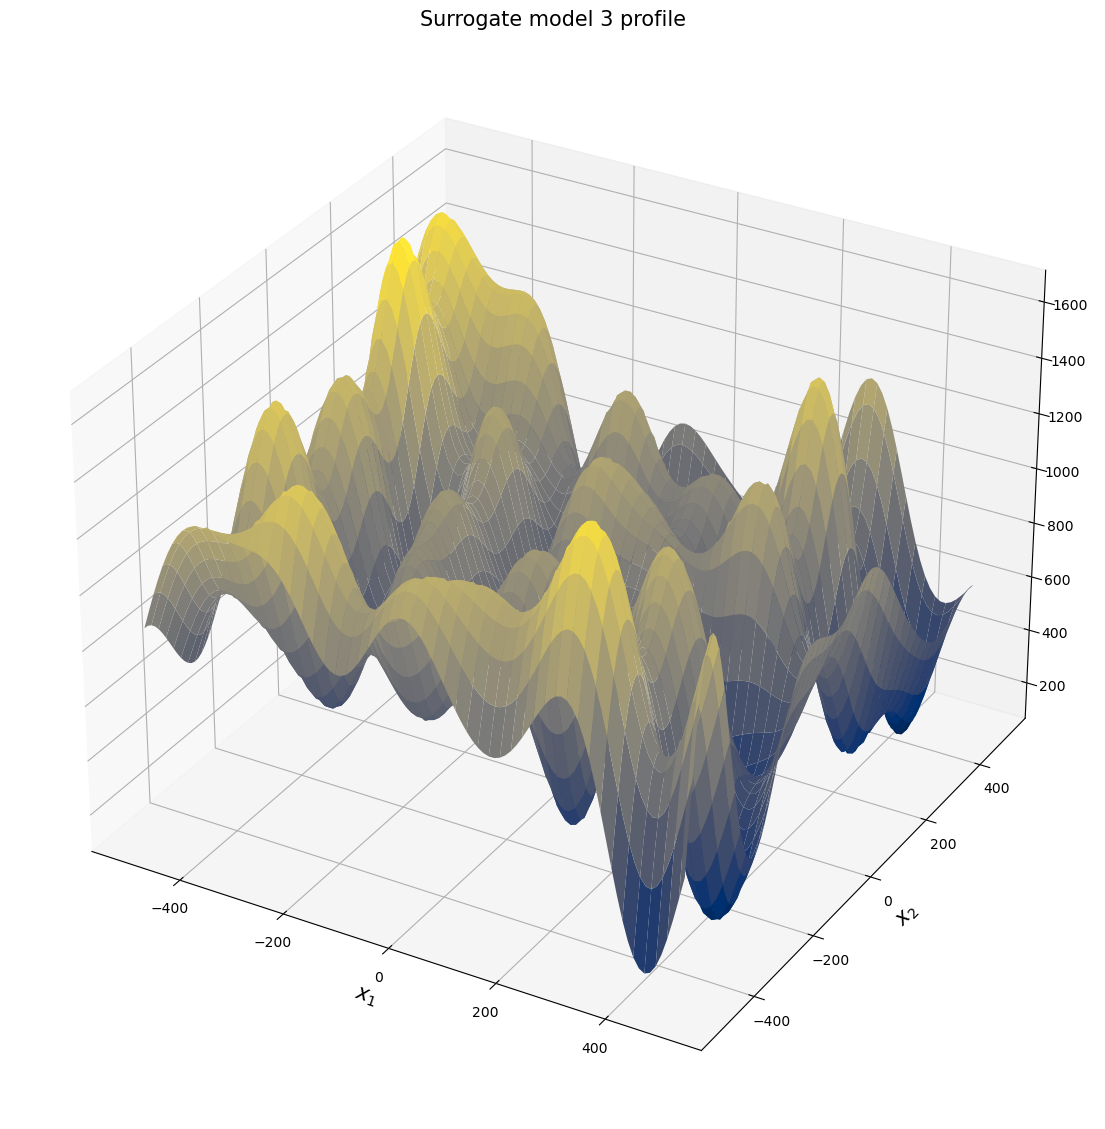

In [14]:
## Code that optimizes fitted GPR model:

import scipy as scp
def gp_model(guess):
    test = np.array([[guess[0],guess[1]]])
    return best_gp.predict(test)[0]

# optimize the best GP model
initial_guess = np.array([[1, 0],
                          [0.25, 0.25],
                          [0.5, 0.75],
                          [0.75, 0.5],
                          [0, 1]])
bnds = ((0, 1), (0, 1))

for i in range(5):
    
    gp_optimize_result = scp.optimize.minimize(gp_model, initial_guess[i,:], bounds=bnds, method='Powell')

    bounds = np.array([[-500, 500], [-500, 500]]).T
    f = y
    # print results
    result_surr_3 = {}
    result_surr_3['x1'] = gp_optimize_result.x[0] * (bounds[1, 0] - bounds[0, 0]) + bounds[0, 0]
    result_surr_3['x2'] = gp_optimize_result.x[1] * (bounds[1, 1] - bounds[0, 1]) + bounds[0, 1]
    result_surr_3['obj'] = gp_optimize_result.fun * (max(f) - min(f)) + min(f)
    print("Optimal solution of GP model with initial guess: " + str(initial_guess[i,:]))
    for key, value in result_surr_3.items():
        print(f"\t{key}:\t{value:.2f}")


## compare model profile

# setup grid
num = 100
x_1_range = np.linspace(-500, 500, num)
x_2_range = np.linspace(-500, 500, num)
x_range = np.transpose(np.array([x_1_range, x_2_range]))
X_1, X_2 = np.meshgrid(x_1_range, x_2_range)


X_1gp, X_2gp = np.meshgrid(np.linspace(0,1, num), np.linspace(0,1, num))

## compute model values
m, n = X_1.shape
surr_3_value = np.zeros((m, n))
blackbox_value = np.zeros((m, n))
error_value= np.zeros((m, n))
for i in range(m):
    for j in range(n):
        surr_3_value[i, j] = best_gp.predict(np.array(((X_1gp[i, j]), X_2gp[i, j])).reshape(1, -1))[0] * (max(f) - min(f)) + min(f)
        
# plot surrogate model
fig = plt.figure(figsize = [14,18])
ax = plt.axes(projection='3d')
ax.plot_surface(X_1, X_2, surr_3_value, cmap='cividis', antialiased=True)
ax.set_xlabel('$x_1$', fontsize=15)
ax.set_ylabel('$x_2$', fontsize=15)
ax.set_title('Surrogate model 3 profile', fontsize=15)



### Answers to Problem 4 here:

A. How do you think the data was collected and is it enough?

    Yes the data should be enough. But other space-filling sampling algorithm like LHS can be used to cover the search space more efficiently

B. Explain what is happening within the cross validation for loop (how many times does it repeat, what is trained, what is calculated on how much data?)
    
    Ten fold cross validation is used here. So there would be 10 sets of (90%, 10%) data respectively as (training, test) data. The loop is repeated 10 times and for each fold the model is trained using the training data (90 data points) and error is calculated on the tests data (10 data points). At the end of the loop, average error accross all fold is reported

C. Is this a good GP model fit? Feel free to change anything in the code to imrpove the GP fit, if there is anything. Describe what you tried. (Do not try other surrogate models, just GPR).

    we can adjust the length scale parameter of the RBF kernel to check if there is any improvement in the performance

    $k(x_i, x_j) = \exp\left(- \frac{d(x_i, x_j)^2}{2l^2} \right)$ 

    where $l$ is the length scale of the kernel and 
    $d(\cdot,\cdot)$ is the Euclidean distance.

D. Use your best fit (regardless of whether you think it is good or not) to find a minimum. Use the code that is provided, which uses Powell's algorithm, which is a local trust-region method. Initialize the algorithm with 5 different points within the scaled space and report the optima you have found. Report all initial points and converged optima. What do you observe and why do you think that is?

    Powell's method is a derivative free local search method. It is dependent on the initial guess for convergence and may lead to local minima based on the initial guess. We can observe the same from the optimization results, the optimum solution found varies with initial guess.
    Optimal solution of GP model with initial guess: [1. 0.]
        x1:	-80.91
        x2:	174.75
        obj:	264.74
    Optimal solution of GP model with initial guess: [0.25 0.25]
        x1:	127.72
        x2:	397.75
        obj:	510.46
    Optimal solution of GP model with initial guess: [0.5  0.75]
        x1:	204.93
        x2:	207.76
        obj:	484.52
    Optimal solution of GP model with initial guess: [0.75 0.5 ]
        x1:	-80.91
        x2:	174.75
        obj:	264.74
    Optimal solution of GP model with initial guess: [0. 1.]
        x1:	-67.96
        x2:	226.89
        obj:	578.05

E. After all the above steps, summarize whether you are happy with this result, if not, provide 2 suggestions on what to do next. 
 
     With a local solver and limited amount of sampling, the optimum solution found is pretty good. Increased sampling/ other space filling sampling design can improve the surrogate accuracy, and global search methods or multistart methods can imprve the optimum solution


## Problem 5: Formulation of ML model (Support Vector Regression) (20 pts)

In the following example, a data set is provided where a single input is affecting a single output. You want to fit a Linear Support Vector Regression model to this data. Formulate the problem in Pyomo (assume you will use all data to train, and there is no need for cross-validation for this problem). Just train a linear SVR on this data (Formulation is on slides of Module 8, Lesson 7, or Notebook for Modules 6-8 (Optimization with Surrogates), and finally use it to predict the data and calculate an error. 

### Tips: 
- A linear SVR has a linear form of y=b+w*x, but the objective function is different. 
- Parameters C, epsilon, are fixed for a given run, you can tune them manually. 
- Slack variables are positive variables that are added to allow for violations of constraints.

Is it a good model for this data, and why (provide as much insight as possible with regards to model fit, data quality etc)?


If you do not get the code to run, explain as much as you can in a Markdown cell, what you would do. 

Termination condition: optimal
estimated parameters : 
w : -9.044444675389736
b : 300.5744575496415
Objective function value @ estimated parameters : 
obj : 233.29969203986286


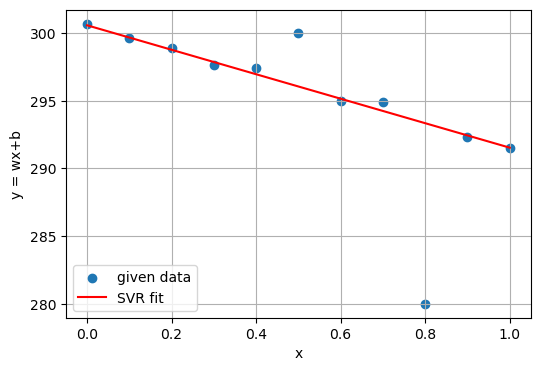

In [15]:
#Define Data:
from pyomo.environ import *
import matplotlib.pyplot as plt

model = ConcreteModel()
model.s = [1,2,3,4,5,6,7,8,9,10,11] #sample
model.yact = {1:300.69, 2:299.67, 3:298.93, 4:297.65, 5:297.39, 6:300, 7:294.95, 8:294.93, 9:280, 10:292.29 ,11:291.53 } 
model.xs = {1:0, 2:0.1, 3:0.2, 4:0.3, 5:0.4, 6:0.5, 7:0.6, 8:0.7, 9:0.8, 10:0.9 ,11:1 } 


#Define Variables:

C = 1e1 #hyper parameter
eps = 1e-5 #tolerance

model.w = Var(within=Reals)
model.b = Var(within=Reals)
model.zeta_p = Var(model.s, within = NonNegativeReals)
model.zeta_n = Var(model.s, within = NonNegativeReals)

def cons1(m,i):
    return model.yact[i] - ( model.b + model.w*model.xs[i]) <= eps + model.zeta_p[i]

def cons2(m,i):
    return ( model.b + model.w*model.xs[i]) - model.yact[i] <= eps + model.zeta_n[i]
 
model.con1 = Constraint(model.s, rule = cons1)
model.con2 = Constraint(model.s, rule = cons2)

def obj(m):
    return 0.5*model.w**2 + C*sum((model.zeta_n[i] + model.zeta_p[i]) for i in model.s)

model.obj = Objective(rule=obj, sense=minimize)

# solve
solver = SolverFactory('ipopt')
results = solver.solve(model)

# print results
print(f"Termination condition: {results.solver.termination_condition}")
print('estimated parameters : ')
print(str(model.w)+' : '+ str(value(model.w)))
print(str(model.b)+' : '+ str(value(model.b)))
print('Objective function value @ estimated parameters : ')
print(str(model.obj)+' : '+ str(value(model.obj)))


y = [(model.yact[key]) for key in model.yact.keys()]
x = [(model.xs[key]) for key in model.xs.keys()]

fig, ax = plt.subplots(figsize=(6,4))
plt.scatter(x, y, label = "given data")
plt.plot(x, [value(model.w)*xval + value(model.b) for xval in x],'r', label = "SVR fit")
plt.xlabel('x')
plt.ylabel('y = wx+b')
plt.legend(loc="lower left")
plt.grid(True)

### Answer Problem 5 here


# The End.. THANK YOU and GOOD LUCK!